In [1]:
import numpy as np
import pandas as pd 
import os
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi=False

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, IntSlider
from tqdm import tqdm_notebook

train_acl = pd.read_csv('../input/mrnet-v1/MRNet-v1.0/train-acl.csv', header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})

train_acl.head()


,Case,Abnormal
0,0000,0
1,0001,1
2,0002,0
3,0003,0
4,0004,0


In [2]:
print(train_acl.shape)

(1130, 2)


In [3]:
train_acl.Abnormal.value_counts(normalize=True)

0    0.815929
1    0.184071
Name: Abnormal, dtype: float64

In [4]:
case = '0000'
#../input/mrnet-v1/MRNet-v1.0/train/axial
mri_coronal = np.load('../input/mrnet-v1/MRNet-v1.0/train/coronal/0000.npy')
mri_axial = np.load('../input/mrnet-v1/MRNet-v1.0/train/axial/0000.npy')
mri_sagittal = np.load('../input/mrnet-v1/MRNet-v1.0/train/sagittal/0000.npy')

print(f'MRI scan on coronal plane: {mri_coronal.shape}')
print(f'MRI scan on axial plane: {mri_axial.shape}')
print(f'MRI scan on sagittal plane: {mri_sagittal.shape}')

MRI scan on coronal plane: (36, 256, 256)
MRI scan on axial plane: (44, 256, 256)
MRI scan on sagittal plane: (36, 256, 256)


In [5]:
print(len(mri_coronal))

36


In [6]:
mri_coronal[1]

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 1, 1, 2],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

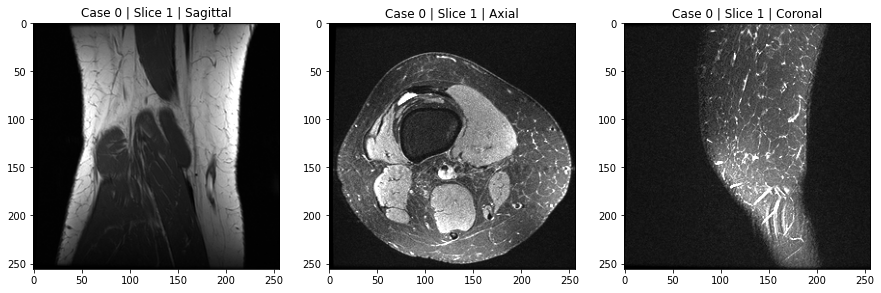

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(mri_coronal[0, :, :], 'gray');
ax1.set_title('Case 0 | Slice 1 | Sagittal');

ax2.imshow(mri_axial[0, :, :], 'gray');
ax2.set_title('Case 0 | Slice 1 | Axial');

ax3.imshow(mri_sagittal[0, :, :], 'gray');
ax3.set_title('Case 0 | Slice 1 | Coronal');

In [8]:
train_path = '../input/mrnet-v1/MRNet-v1.0/train/'

def load_one_stack(case, data_path=train_path, plane='coronal'):
    fpath = '{}/{}/{}.npy'.format(data_path, plane, case)
    return np.load(fpath)

def load_stacks(case, data_path=train_path):
    x = {}
    planes = ['coronal', 'sagittal', 'axial']
    for i, plane in enumerate(planes):
        x[plane] = load_one_stack(case, plane=plane)
    return x

def load_cases(train=True, n=None):
    assert (type(n) == int) and (n < 1250)
    if train:
        case_list = pd.read_csv('../input/mrnet-v1/MRNet-v1.0/train-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()        
    else:
        case_list = pd.read_csv('../input/mrnet-v1/MRNet-v1.0/valid-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()        
    cases = {}
    
    if n is not None:
        case_list = case_list[:n]
        
    for case in tqdm_notebook(case_list, leave=False):
        x = load_stacks(case)
        cases[case] = x
    return cases

cases = load_cases(n=100)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
print(cases['0000'].keys())

dict_keys(['coronal', 'sagittal', 'axial'])


In [10]:
print(cases['0000']['axial'].shape)
print(cases['0000']['coronal'].shape)
print(cases['0000']['sagittal'].shape)

(44, 256, 256)
(36, 256, 256)
(36, 256, 256)


In [11]:
pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=cd355969187c736c91916d7e3615a715a14673066097cb38a46f4b14f307d7c1
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

# Extracting the region of interest

In [13]:
import cv2
def crop_contour_brain_img(image, plot = False):
    #grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayscale = cv2.GaussianBlur(image, (5,5), 0)
    threshold_image = cv2.threshold(grayscale, 45, 255, cv2.THRESH_BINARY)[1]
    threshold_image = cv2.erode(threshold_image, None, iterations = 2)
    threshold_image = cv2.dilate(threshold_image, None, iterations = 2)
    
    contour = cv2.findContours(threshold_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = imutils.grab_contours(contour)
    c = max(contour, key = cv2.contourArea)
    
    extreme_pnts_left = tuple(c[c[:,:, 0].argmin()][0])
    extreme_pnts_right = tuple(c[c[:,:, 0].argmax()][0])
    extreme_pnts_top = tuple(c[c[:,:, 1].argmin()][0])
    extreme_pnts_bot = tuple(c[c[:,:, 1].argmax()][0])
    
    new_image = image[extreme_pnts_top[1]:extreme_pnts_bot[1], extreme_pnts_left[0]:extreme_pnts_right[0]]
    new_image = cv2.resize(new_image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    
    
    if plot:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(example_image, 'gray')
        plt.tick_params(axis = 'both', which = 'both', top = False, bottom = False, left = False, right = False, labelbottom = False,
                       labeltop = False, labelright = False, labelleft = False)
        plt.title('original image')
        plt.subplot(1,2,2)
        plt.imshow(new_image, 'gray')
        
        plt.tick_params(axis = 'both', which = 'both', top = False, bottom = False, left = False, right = False, labelbottom = False,
                       labeltop = False, labelright = False, labelleft = False )
        plt.title('cropped image')
    return new_image

array([[  0,   0,   0, ...,  49,  50,  50],
       [  0,   0,   0, ...,  89,  95,  83],
       [  1,   1,   1, ..., 128, 149, 119],
       ...,
       [ 59,  70,  70, ...,   2,   2,   2],
       [ 67,  70,  65, ...,   2,   2,   2],
       [ 51,  60,  62, ...,   2,   2,   2]], dtype=uint8)

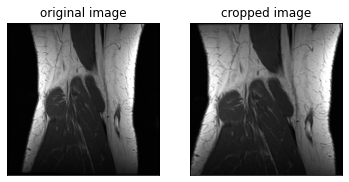

In [14]:
example_image = mri_coronal[0, :, :]
#example_image = np.mean(example_image, axis=2)
crop_contour_brain_img(example_image, plot = True)

array([[22, 17, 17, ..., 18, 15, 13],
       [19, 14, 17, ..., 17, 18, 14],
       [23, 20, 20, ..., 13, 14, 15],
       ...,
       [18, 19, 19, ..., 13, 18, 18],
       [19, 19, 20, ..., 14, 16, 17],
       [16, 20, 17, ..., 15, 18, 18]], dtype=uint8)

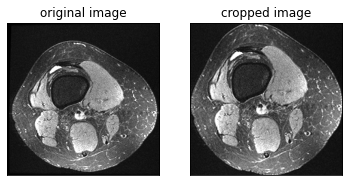

In [15]:
example_image = mri_axial[0, :, :]
#example_image = np.mean(example_image, axis=2)
crop_contour_brain_img(example_image, plot = True)

array([[ 0,  0,  0, ..., 26, 24, 22],
       [ 7,  6,  6, ..., 64, 62, 59],
       [15, 14, 13, ..., 81, 81, 80],
       ...,
       [18, 21, 23, ..., 26, 26, 26],
       [22, 20, 17, ..., 22, 25, 27],
       [12, 10,  8, ..., 21, 20, 19]], dtype=uint8)

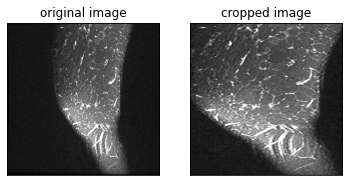

In [16]:
example_image = mri_sagittal[0, :, :]
#example_image = np.mean(example_image, axis=2)
crop_contour_brain_img(example_image, plot = True)

In [17]:
mri_sagittal[0, :, :]

array([[ 0,  0,  0, ...,  1,  1,  2],
       [ 0,  0,  0, ...,  8,  8,  7],
       [ 0,  0,  0, ..., 15, 16, 14],
       ...,
       [ 0,  1,  1, ..., 15, 12, 11],
       [ 0,  0,  0, ...,  7,  6,  5],
       [ 0,  0,  0, ...,  2,  2,  1]], dtype=uint8)

In [18]:
from __future__ import print_function
from __future__ import absolute_import
#from tf.keras.utils.utils.layer_utils import convert_all_kernels_in_model
from keras.layers import Input
from keras.optimizers import Adam
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
from keras.preprocessing import image
from imgaug import augmenters as iaa
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.engine.topology import get_source_inputs
from keras.layers import GlobalMaxPooling1D, Dense, Conv1D,Conv2D
from keras import regularizers,optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import (merge, Lambda)
from keras.layers.convolutional import (Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D)
import matplotlib.pyplot as plt
import random as random
import warnings,gc,csv,keras,os,sys
import imgaug as ia
import pandas as pd
import numpy as np
from keras.models import Model
from keras.regularizers import l2
import keras.backend as K

In [19]:
train_axial_dir='../input/mrnet-v1/MRNet-v1.0/train/axial'
train_coronal_dir= '../input/mrnet-v1/MRNet-v1.0/train/coronal'
train_sagittal_dir= '../input/mrnet-v1/MRNet-v1.0/train/sagittal'

train_abnormal_labels= '../input/mrnet-v1/MRNet-v1.0/train-abnormal.csv'
train_acl_labels= '../input/mrnet-v1/MRNet-v1.0/train-acl.csv'
train_meniscus_labels= '../input/mrnet-v1/MRNet-v1.0/train-meniscus.csv'

In [20]:
def extract_center(image):
    aug = []
    for i in range(len(image)):
        aug.append(crop_contour_brain_img(image[i], plot = False))
    aug = np.array(aug)
    return aug 

In [21]:
def augment(image):
  aug=[]
  for s in range(len(image)):
      aug.append(ia.imresize_single_image(image[s], (224, 224)))
  aug=np.array(aug)
  return aug

def clear():
  aug= None
  gc.collect()

# To add the third channel(to color the image).
def add_rgb(grey_img):
  rgb_img = np.repeat(grey_img[..., np.newaxis], 3, -1)
  return rgb_img

# Load data, to skip metadata file.
def load_data(path):
  data = []
  for d in sorted(os.listdir(path)):
    if d!='.DS_Store':
      data.append(d)
      print("in iterator ", d)
      clear()
  return data

# Load labels from CSV files.  
def load_labels(path):
  labels = []
  read = pd.read_csv(path, names=['num', 'hot'])
  labels = list(read['hot'])
  return labels

def plot_graphs(y):
  plt.plot( epochs,y.history['accuracy'],'r')
  plt.xlabel("Epochs")
  plt.ylabel("accuracy")
  plt.title("Accuracy vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['val_accuracy'],'b')
  plt.xlabel("Epochs")
  plt.ylabel("val_accuracy")
  plt.title("Vlidation Acuuracy vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['loss'],'g')
  plt.xlabel("Epochs")
  plt.ylabel("loss")
  plt.title("Loss vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['val_loss'],'k')
  plt.xlabel("Epochs")
  plt.ylabel("val_loss")
  plt.title("Validation Loss vs Epochs")
  plt.show()

#Hyperparameters 
def Average(lst): 
    return sum(lst) / len(lst) 

# Loop over dataset for 300 times.
epoch=10
epochs=[0]*epoch
for i in range(0,epoch):
  epochs[i]=i

In [22]:
print("##############     Load Axial Data   ##############")
train_axial_data = os.listdir(train_axial_dir)

print("##############     Load Cronal Data   ##############")
train_coronal_data = os.listdir(train_coronal_dir)

print("##############     Load Sagital Data   ##############")
train_sagittal_data = os.listdir(train_sagittal_dir)

print("##############  Load Abnormal Labels   ##############")
train_abnormal_labels = load_labels(train_abnormal_labels)

print("##############  Load ACL Labels   ##############")
train_acl_labels = load_labels(train_acl_labels)

print("##############  Load Meniscus Labels   ##############")
train_meniscus_labels = load_labels(train_meniscus_labels)

##############     Load Axial Data   ##############
##############     Load Cronal Data   ##############
##############     Load Sagital Data   ##############
##############  Load Abnormal Labels   ##############
##############  Load ACL Labels   ##############
##############  Load Meniscus Labels   ##############


In [23]:
val_axial_dir = '../input/mrnet-v1/MRNet-v1.0/valid/axial'
val_coronal_dir = '../input/mrnet-v1/MRNet-v1.0/valid/coronal'
val_sagittal_dir = '../input/mrnet-v1/MRNet-v1.0/valid/sagittal'

val_abnormal_labels= '../input/mrnet-v1/MRNet-v1.0/valid-abnormal.csv'
val_acl_labels= '../input/mrnet-v1/MRNet-v1.0/valid-acl.csv'
val_meniscus_labels= '../input/mrnet-v1/MRNet-v1.0/valid-meniscus.csv'

val_axial_data = os.listdir(val_axial_dir)
val_coronal_data = os.listdir(val_coronal_dir)
val_sagittal_data =  os.listdir(val_sagittal_dir)


val_abnormal_labels= load_labels(val_abnormal_labels)
val_meniscus_labels= load_labels(val_meniscus_labels)
val_acl_labels= load_labels(val_acl_labels)

# DenseNet201

In [28]:
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet169
from keras.applications import DenseNet201
def build_densenet():
    densenet = DenseNet201(weights='imagenet', include_top=False)

    input = Input(shape=(224, 224, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = densenet(x)
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    x = Concatenate(axis=-1)([out1, out2, out3])
    x = Dropout(0.5)(x)
    output = Dense(1,activation = 'sigmoid', name='root')(x)
    model = Model(input,output)
    optimizer = Adam(lr=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model
model = build_densenet()
checkpoint = ModelCheckpoint('model_1.h5', verbose=1, monitor = 'val_acc', save_best_only=True, mode='max')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 3)  84          input_4[0][0]                    
__________________________________________________________________________________________________
densenet201 (Functional)        (None, None, None, 1 18321984    conv2d_1[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 1920)         0           densenet201[0][0]                
____________________________________________________________________________________________

In [29]:
# Training Data length
axialt_length = len(train_axial_data)
coronalt_length = len(train_coronal_data)
saggitalt_length= len(train_sagittal_data)

# Validiation Data length
axialv_length = len(val_axial_data)
coronalv_length = len(val_coronal_data)
saggitalv_length = len(val_sagittal_data)

In [30]:
# Data Generation and Shuffle Method.
def data_gen(data,label,path,data_length):
  all_data = list(zip(data,label))
  random.shuffle(all_data)
  i = 0
  while(True):
    if(i == data_length):
      yield(None,None)
      break
    for pair in all_data:
      if(pair[0] != '.DS_Store'):
        img = np.load(os.path.join(path,pair[0]),allow_pickle=True)
        img = img.astype(np.uint8)
        #img_aug = augment(img)
        img_aug = extract_center(img)
        img_aug = add_rgb(img_aug)
        yield (img_aug,np.repeat(pair[1],img_aug.shape[0]))
    i += 1

In [31]:
# Data Generation For Abnormal Training Data {axial-coronal-sagittal}
axial_abnormal = data_gen(train_axial_data , train_abnormal_labels,train_axial_dir,axialt_length)
coronal_abnormal = data_gen(train_coronal_data,train_abnormal_labels,train_coronal_dir,coronalt_length)
sagittal_abnormal= data_gen(train_sagittal_data,train_abnormal_labels,train_sagittal_dir,saggitalt_length)
# Data Generation For Abnormal Validiation Data {axial-coronal-sagittal}
axial_abnormal_val = data_gen(train_axial_data , val_abnormal_labels,train_axial_dir,axialv_length)
coronal_abnormal_val = data_gen(train_coronal_data , val_abnormal_labels,train_axial_dir,coronalv_length)
sagittal_abnormal_val = data_gen(train_sagittal_data , val_abnormal_labels,train_axial_dir,saggitalv_length)
# Data Generation For Acl Training Data {axial-coronal-sagittal}
axial_acl = data_gen(train_axial_data , train_acl_labels,train_axial_dir,axialt_length)
coronal_acl = data_gen(train_coronal_data,train_acl_labels,train_coronal_dir,coronalt_length)
sagittal_acl = data_gen(train_sagittal_data,train_acl_labels,train_sagittal_dir,saggitalt_length)
# Data Generation For ACL Validiation Data {axial-coronal-sagittal}
axial_acl_val = data_gen(train_axial_data , val_acl_labels,train_axial_dir,axialv_length)
coronal_acl_val = data_gen(train_coronal_data , val_acl_labels,train_axial_dir,coronalv_length)
sagittal_acl_val = data_gen(train_sagittal_data , val_acl_labels,train_axial_dir,saggitalv_length)
# Data Generation For Meniscus Training Data {axial-coronal-sagittal}
axial_meniscus = data_gen(train_axial_data , train_meniscus_labels,train_axial_dir,axialt_length)
coronal_meniscus = data_gen(train_coronal_data,train_meniscus_labels,train_coronal_dir,coronalt_length)
sagittal_meniscus = data_gen(train_sagittal_data,train_meniscus_labels,train_sagittal_dir,saggitalt_length)
# Data Generation For Meniscus Validiation Data {axial-coronal-sagittal}
axial_meniscus_val = data_gen(train_axial_data , val_meniscus_labels,train_axial_dir,axialv_length)
coronal_meniscus_val = data_gen(train_coronal_data , val_meniscus_labels,train_axial_dir,coronalv_length)
sagittal_meniscus_val = data_gen(train_sagittal_data , val_meniscus_labels,train_axial_dir,saggitalv_length)

In [32]:
from keras.preprocessing.image import ImageDataGenerator
abnormalAccuracys=[]
axial_abnormal = model.fit(axial_abnormal, epochs = 3,steps_per_epoch= axialt_length, callbacks=[checkpoint], validation_data= axial_abnormal_val,validation_steps=axialv_length)
abnormalAccuracys.append(Average(axial_abnormal.history['val_accuracy']))

Epoch 1/3
1130/1130 [==============================] - 481s 402ms/step - loss: 1.0052 - accuracy: 0.7167 - val_loss: 1.2226 - val_accuracy: 0.7933
Epoch 2/3
1130/1130 [==============================] - 365s 323ms/step - loss: 0.7671 - accuracy: 0.7610 - val_loss: 0.9236 - val_accuracy: 0.7933
Epoch 3/3
1130/1130 [==============================] - 364s 322ms/step - loss: 0.7627 - accuracy: 0.7673 - val_loss: 1.0185 - val_accuracy: 0.7933


In [33]:
coronal_abnormal = model.fit(coronal_abnormal, epochs = 3,steps_per_epoch= coronalt_length,validation_data= coronal_abnormal_val,validation_steps=coronalv_length )
abnormalAccuracys.append(Average(coronal_abnormal.history['val_accuracy']))
#plot_graphs(coronal_abnormal)

Epoch 1/3
1130/1130 [==============================] - 331s 293ms/step - loss: 0.7507 - accuracy: 0.7690 - val_loss: 0.5528 - val_accuracy: 0.7933
Epoch 2/3
1130/1130 [==============================] - 328s 290ms/step - loss: 0.7313 - accuracy: 0.7727 - val_loss: 0.5257 - val_accuracy: 0.7933
Epoch 3/3
1130/1130 [==============================] - 327s 290ms/step - loss: 0.7031 - accuracy: 0.7735 - val_loss: 6.2420 - val_accuracy: 0.7516


In [34]:
sagittal_abnormal = model.fit(sagittal_abnormal, epochs = 3,steps_per_epoch= saggitalt_length,callbacks=[checkpoint],validation_data= sagittal_abnormal_val,validation_steps=saggitalv_length )
abnormalAccuracys.append(Average(sagittal_abnormal.history['val_accuracy']))

Epoch 1/3
1130/1130 [==============================] - 330s 292ms/step - loss: 0.7410 - accuracy: 0.7735 - val_loss: 111.0651 - val_accuracy: 0.7933
Epoch 2/3
1130/1130 [==============================] - 332s 294ms/step - loss: 0.7159 - accuracy: 0.7812 - val_loss: 0.5153 - val_accuracy: 0.7933
Epoch 3/3
1130/1130 [==============================] - 331s 293ms/step - loss: 0.7220 - accuracy: 0.7795 - val_loss: 100.6998 - val_accuracy: 0.7936


In [36]:
print(len(abnormalAccuracys))

3


In [37]:
print("Accuracy Abnormal = ",Average(abnormalAccuracys)*100,"%")

Accuracy Abnormal =  78.87203494707742 %
